# Ансамбли

**Автор**: Винник Екатерина Петровна, 22.М04

## Задача

- [+] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [+] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [+] Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [+] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- [ ] При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- [+] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [+] * (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- [ ] * (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

## EDA

Загрузим данные.

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore') 

train_df=pd.read_csv('./train.csv')
test_df=pd.read_csv('./test.csv')

train_df.shape, test_df.shape

train_df['label']='train'
test_df['label']='test'

combined_data_df=pd.concat([train_df,test_df])
combined_data_df.shape

(44856, 16)

Посмотрим на то, какие типы данных присутствуют в датасете.

In [2]:
combined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44856 entries, 0 to 898
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              44856 non-null  int64  
 1   workclass        42358 non-null  object 
 2   fnlwgt           44856 non-null  int64  
 3   education        44856 non-null  object 
 4   educational-num  44856 non-null  int64  
 5   marital-status   44856 non-null  object 
 6   occupation       42350 non-null  object 
 7   relationship     44856 non-null  object 
 8   race             44856 non-null  object 
 9   gender           44856 non-null  object 
 10  capital-gain     44856 non-null  int64  
 11  capital-loss     44856 non-null  int64  
 12  hours-per-week   44856 non-null  int64  
 13  native-country   44093 non-null  object 
 14  income_>50K      43957 non-null  float64
 15  label            44856 non-null  object 
dtypes: float64(1), int64(6), object(9)
memory usage: 5.8+ MB


Видно, что в датасете присутствуют как количественные, так и категориальные признаки. Посмотрим, есть ли в датасете пропущенные значения.

In [3]:
combined_data_df.isnull().sum()

age                   0
workclass          2498
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      763
income_>50K         899
label                 0
dtype: int64

Пропущенные значения есть только у категориальных признаков, при этом количество пропущенных значений $(2498 + 2506 + 763 + 899) / 44856 \sim 1\%$ от всего датасета, поэтому их можно удалить.

In [4]:
combined_data_df.dropna(subset=['workclass','occupation','native-country'],axis=0,inplace=True)
combined_data_df.isnull().sum()

age                  0
workclass            0
fnlwgt               0
education            0
educational-num      0
marital-status       0
occupation           0
relationship         0
race                 0
gender               0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country       0
income_>50K        899
label                0
dtype: int64

#### Изучение отдельных признаков

Рассмотрим признак *workclass*.

<AxesSubplot: xlabel='workclass', ylabel='count'>

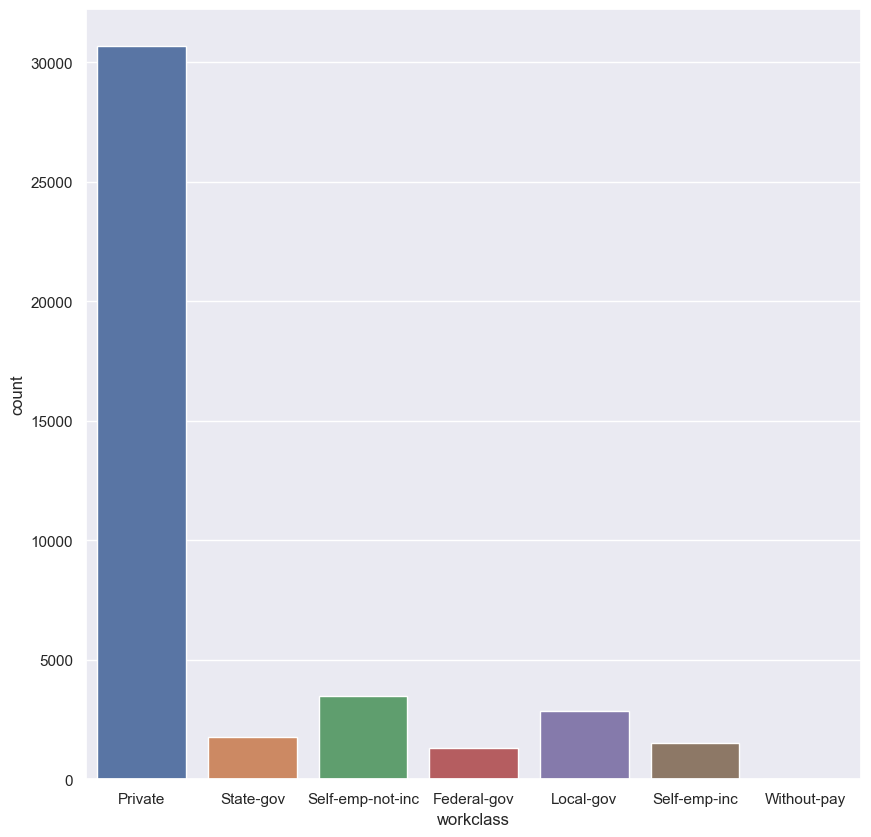

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

#frequency distribution of work class
plt.figure(figsize=(10,10))
sns.countplot(data= combined_data_df, x = combined_data_df['workclass'])

Из графика видно, что большинство людей работают в частном сегменте, и почти 0 людей работают бесплатно (имеют значение признака *workclass* равным *without-pay*).
Поэтому можем удалить строки со значением *without-pay* из датасета.

In [6]:
combined_data_df.drop(combined_data_df.index[combined_data_df['workclass'] == 'Without-pay'], inplace=True)
combined_data_df.shape

(41606, 16)

Рассмотрим признак циональности (*native-country*).

<AxesSubplot: xlabel='count', ylabel='native-country'>

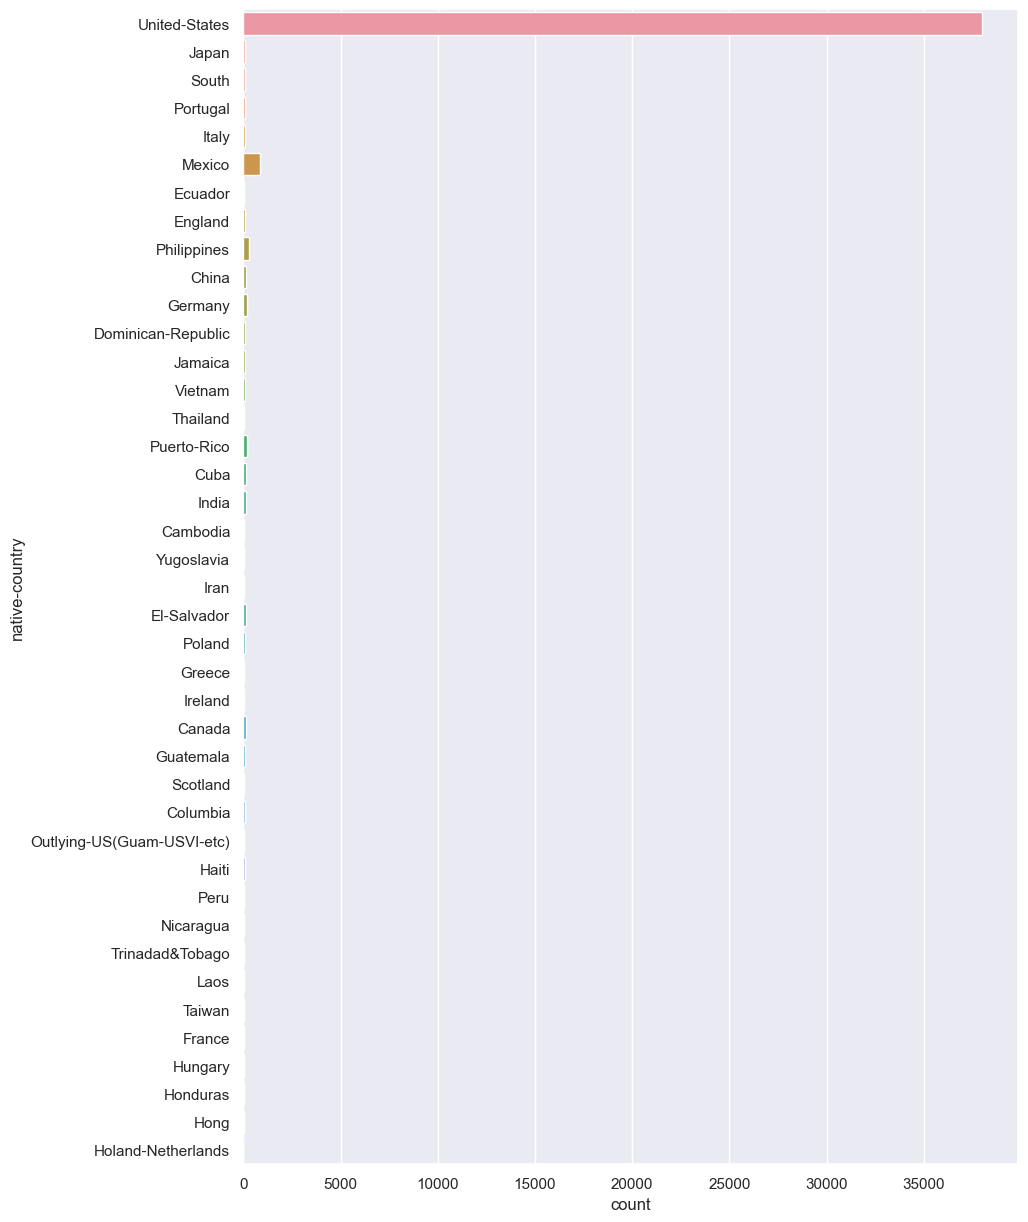

In [7]:
plt.figure(figsize=(10,15))
sns.countplot(data= combined_data_df, y = "native-country")

Из графика видно, что подавляющее большинство людей в датасете родились в США. Поэтому можем удалить этот признак.

In [8]:
combined_data_df=combined_data_df.drop(columns='native-country',axis=1)
combined_data_df.shape

(41606, 15)

Изучим, каким образованием обладают люди из датасета.

<AxesSubplot: xlabel='education', ylabel='count'>

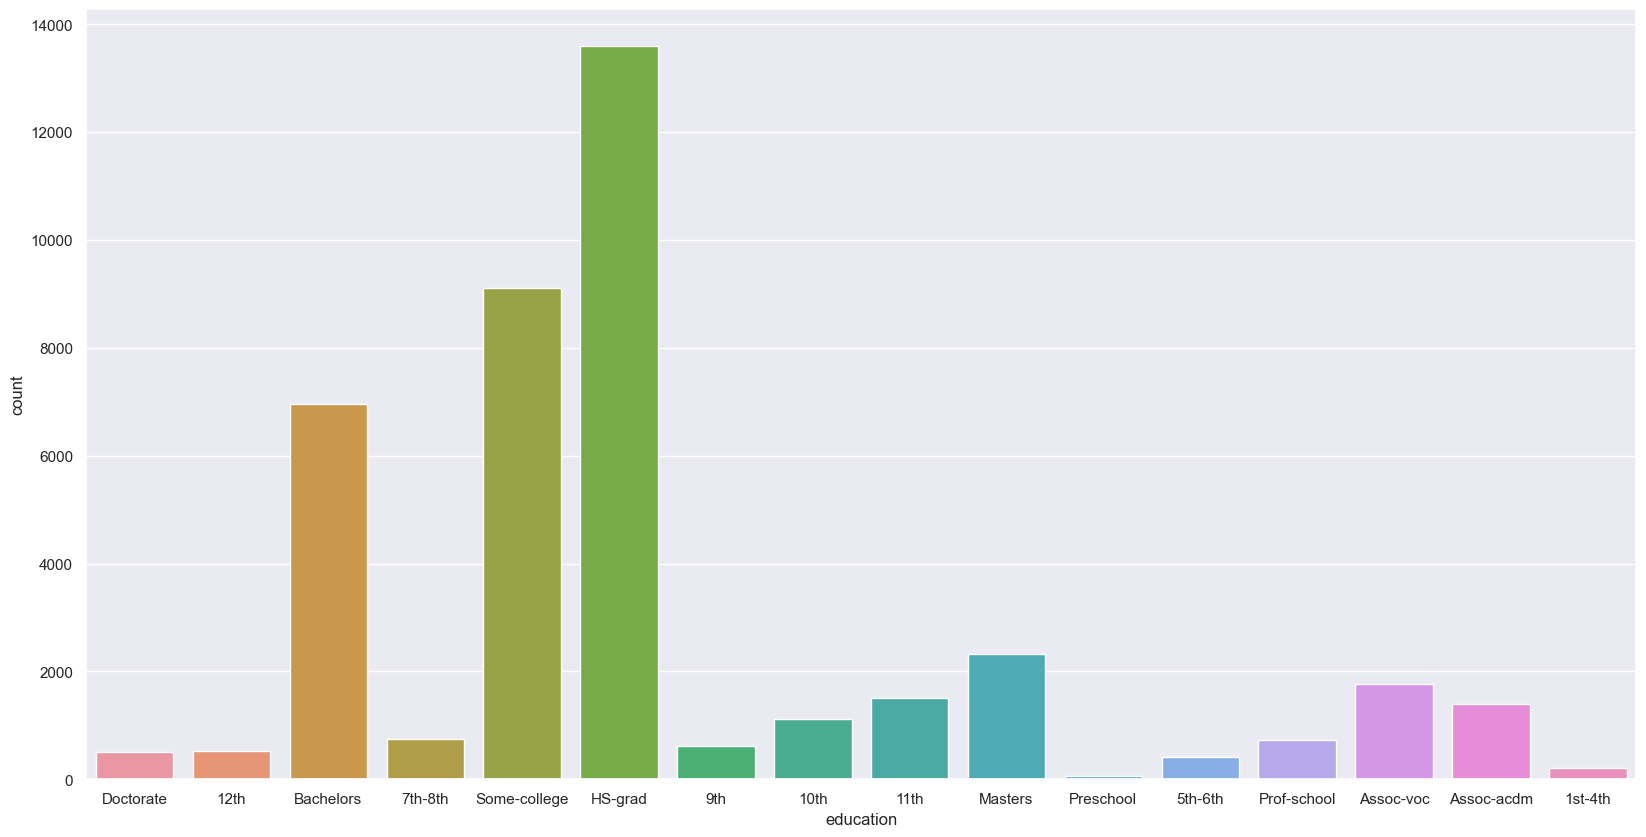

In [9]:
plt.figure(figsize=(20,10))
sns.countplot(data= combined_data_df, x = "education")

Из графика видно, что есть достаточное количество людей, обучающихся в каком-то из 1 - 12 классов школы. Можно сгруппировать классы школы в новые признаки -- начальную школу, среднюю школу и старшую школу, сократив тем самым количество возможных значений признака.

In [10]:
combined_data_df['education'] = combined_data_df['education'].replace(['1st-4th','5th-6th'],'elementary-school')
combined_data_df['education'] = combined_data_df['education'].replace(['7th-8th'],'middle-school')
combined_data_df['education'] = combined_data_df['education'].replace(['9th','10th','11th','12th'],'high-school')
combined_data_df['education'] = combined_data_df['education'].replace(['Doctorate','Bachelors','Some-college','Masters','Prof-school','Assoc-voc','Assoc-acdm'],'postsecondary-education')

Рассмотрим значения признака "образование" после группировки школьников по классам.

<AxesSubplot: xlabel='education', ylabel='count'>

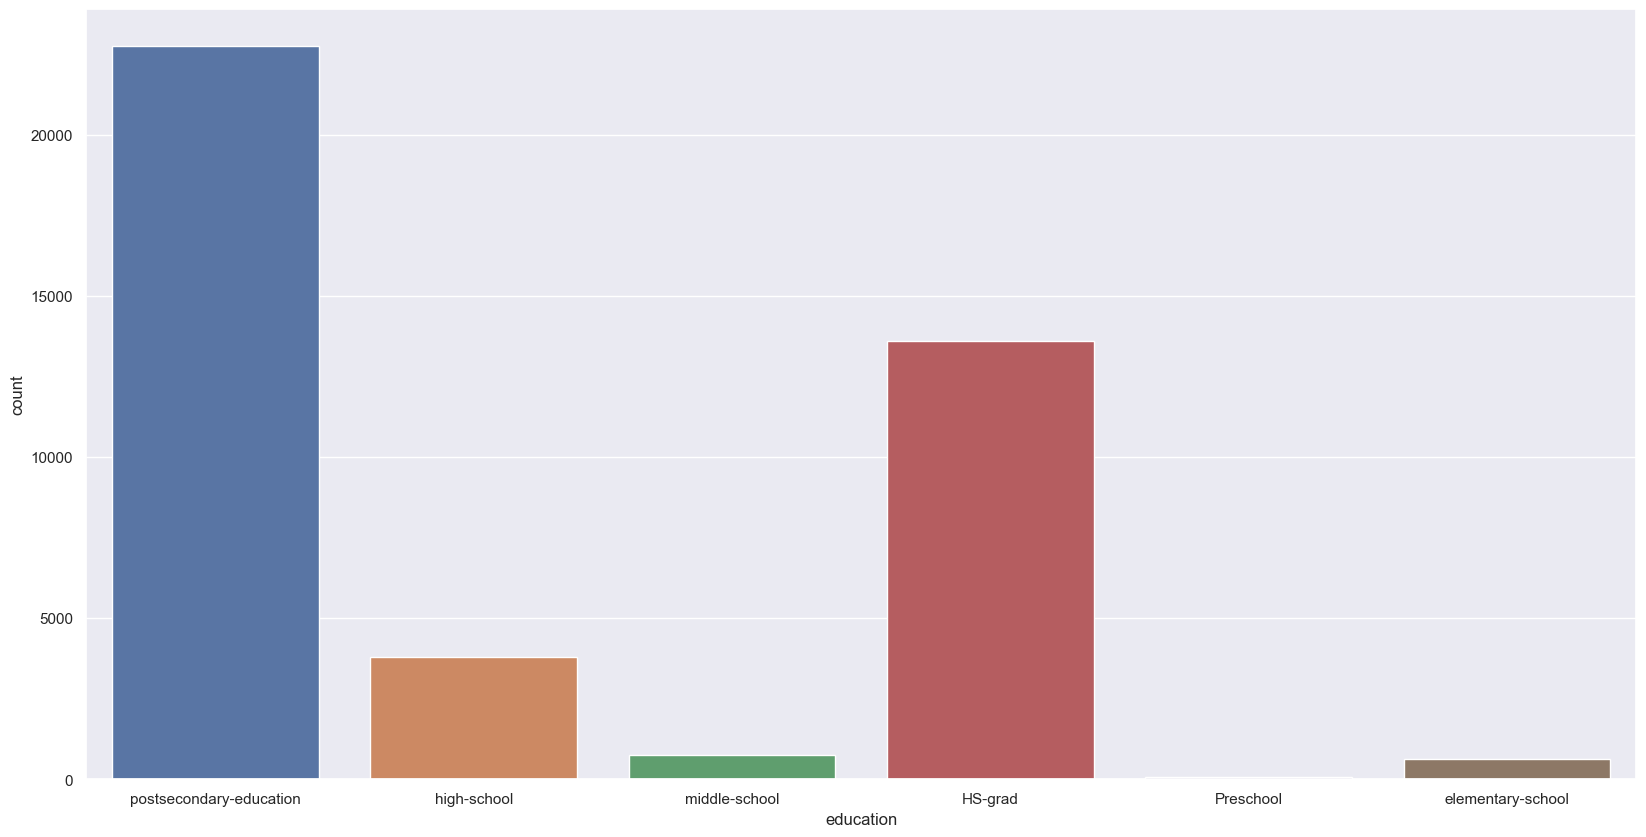

In [11]:
plt.figure(figsize=(20,10))
sns.countplot(data= combined_data_df, x = "education")

Рассмотрим, каким семейным положением обладают люди из датасета.

<AxesSubplot: xlabel='marital-status', ylabel='count'>

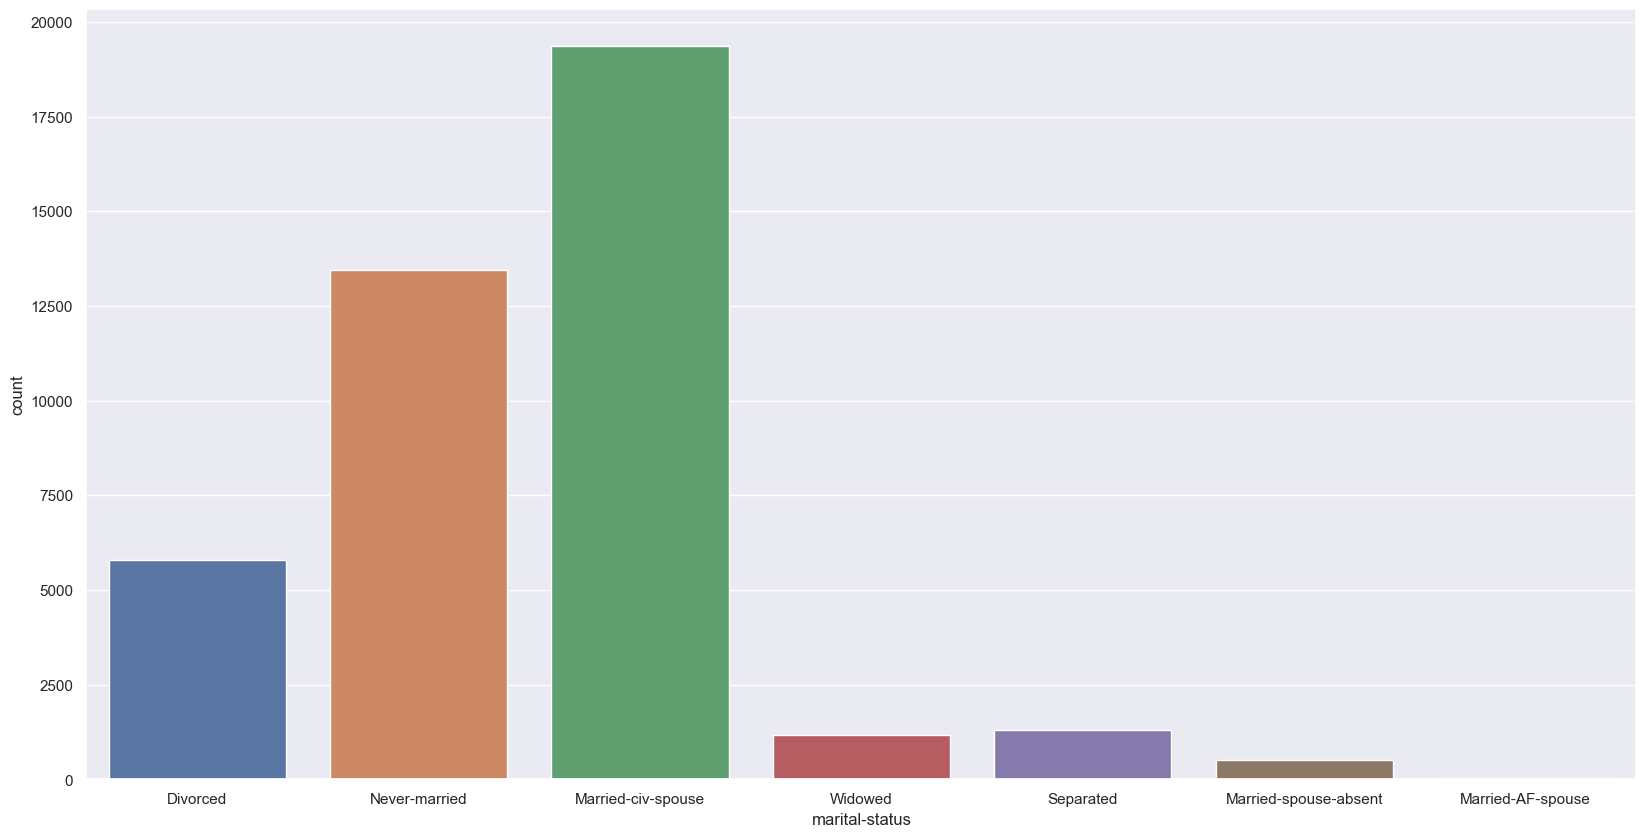

In [12]:
plt.figure(figsize=(20,10))
sns.countplot(data= combined_data_df, x = "marital-status")

Из графика видно, что больше всего людей обладают статусом "Married-civ-spouse" (женаты), а на втором месте люди, еще никогда не женившиеся.

Все значения признака "marital-status" могут быть объединены в две группы:

$divorced+never-married+widowed = single$


$married-civ-spouse+separated+married-spouse-absent+married-AF-spouse = married$

На основании этого наблюдения переформируем значения признака.

In [13]:
combined_data_df['marital-status'] = combined_data_df['marital-status'].replace(['Divorced','Never-married','Widowed'],'single')
combined_data_df['marital-status'] = combined_data_df['marital-status'].replace(['Married-civ-spouse','Separated','Married-spouse-absent','Married-AF-spouse'],'married')

Рассмотрим получившиеся значения признака "marital-status".

<AxesSubplot: xlabel='marital-status', ylabel='count'>

<Figure size 2000x1000 with 0 Axes>

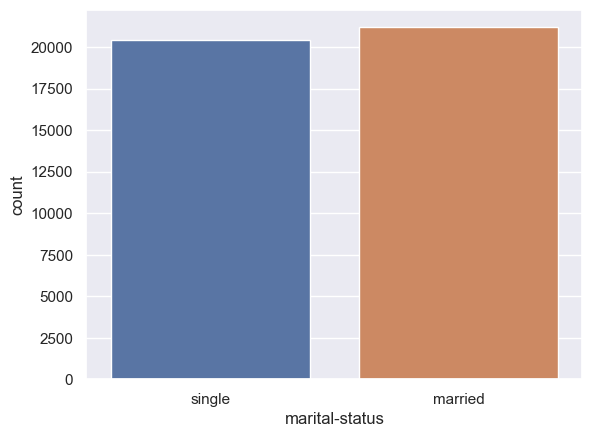

In [14]:
plt.figure(figsize=(20,10))
plt.figure()
sns.countplot(data= combined_data_df, x = "marital-status")

Из графика видно, что не женатых людей почти столько же, сколько женатых.

Посмотрим на род занятий ("occupation") людей из датасета.

<AxesSubplot: xlabel='count', ylabel='occupation'>

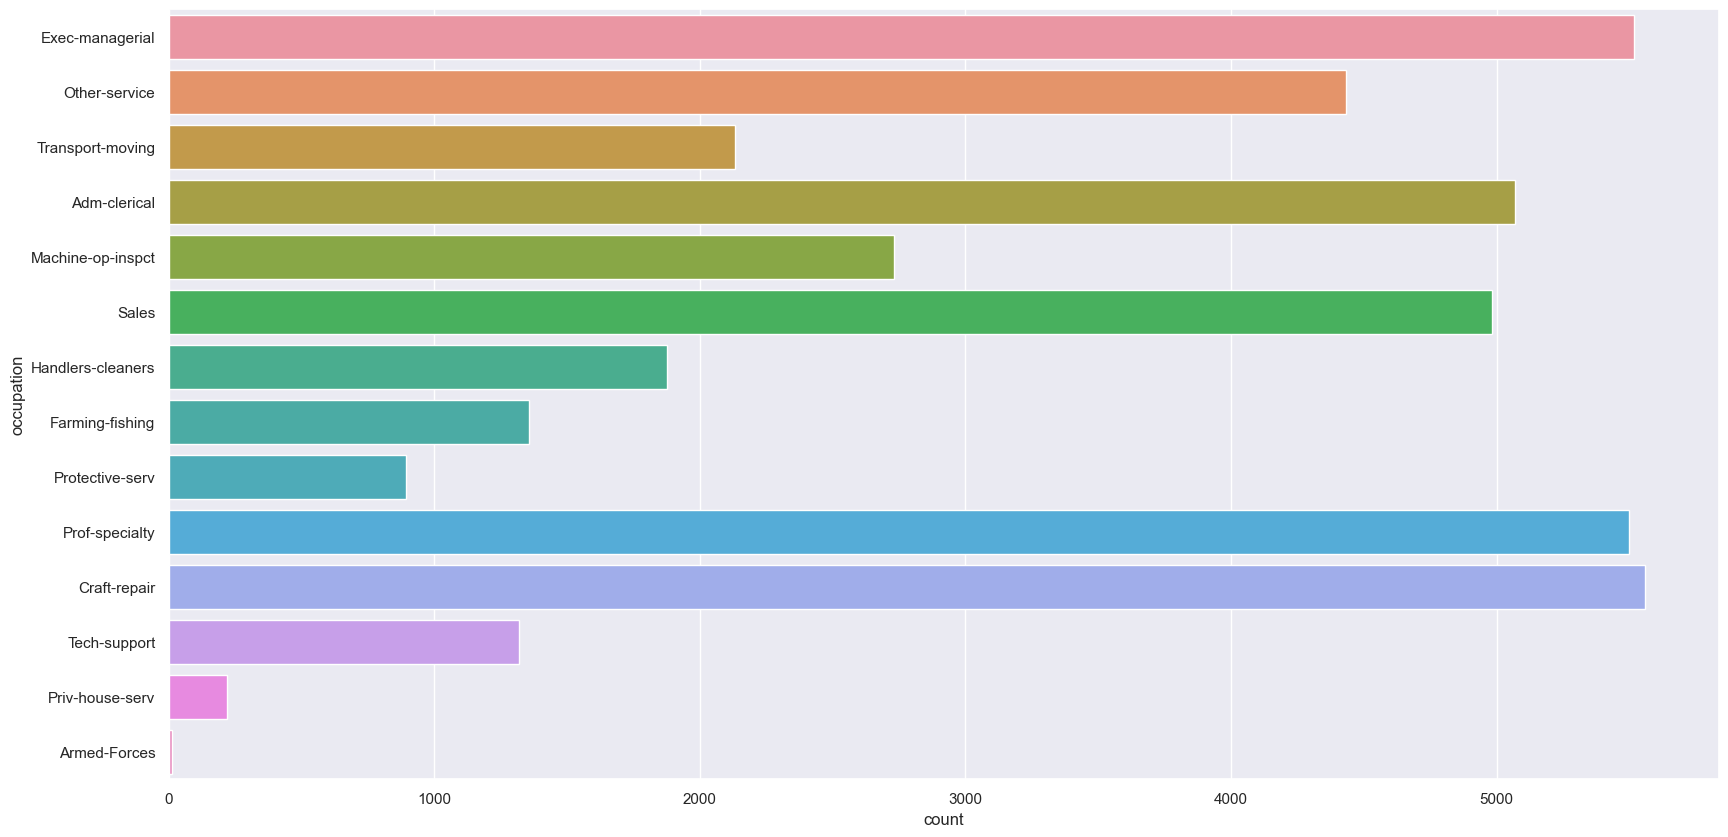

In [15]:
plt.figure(figsize=(20,10)) 
sns.countplot(data= combined_data_df, y = "occupation")

Из графика видно, что очень много людей работают в должности исполнительного директора ("exec-managerial"), много людей работают по какой-то специфичной профессии ("Prof-specialty"), чуть меньше людей работают в сфере продаж ("Sales") и административной сфере ("Adm-clerical").

Рассмотрим родственные связи людей датасета.

<AxesSubplot: xlabel='relationship', ylabel='count'>

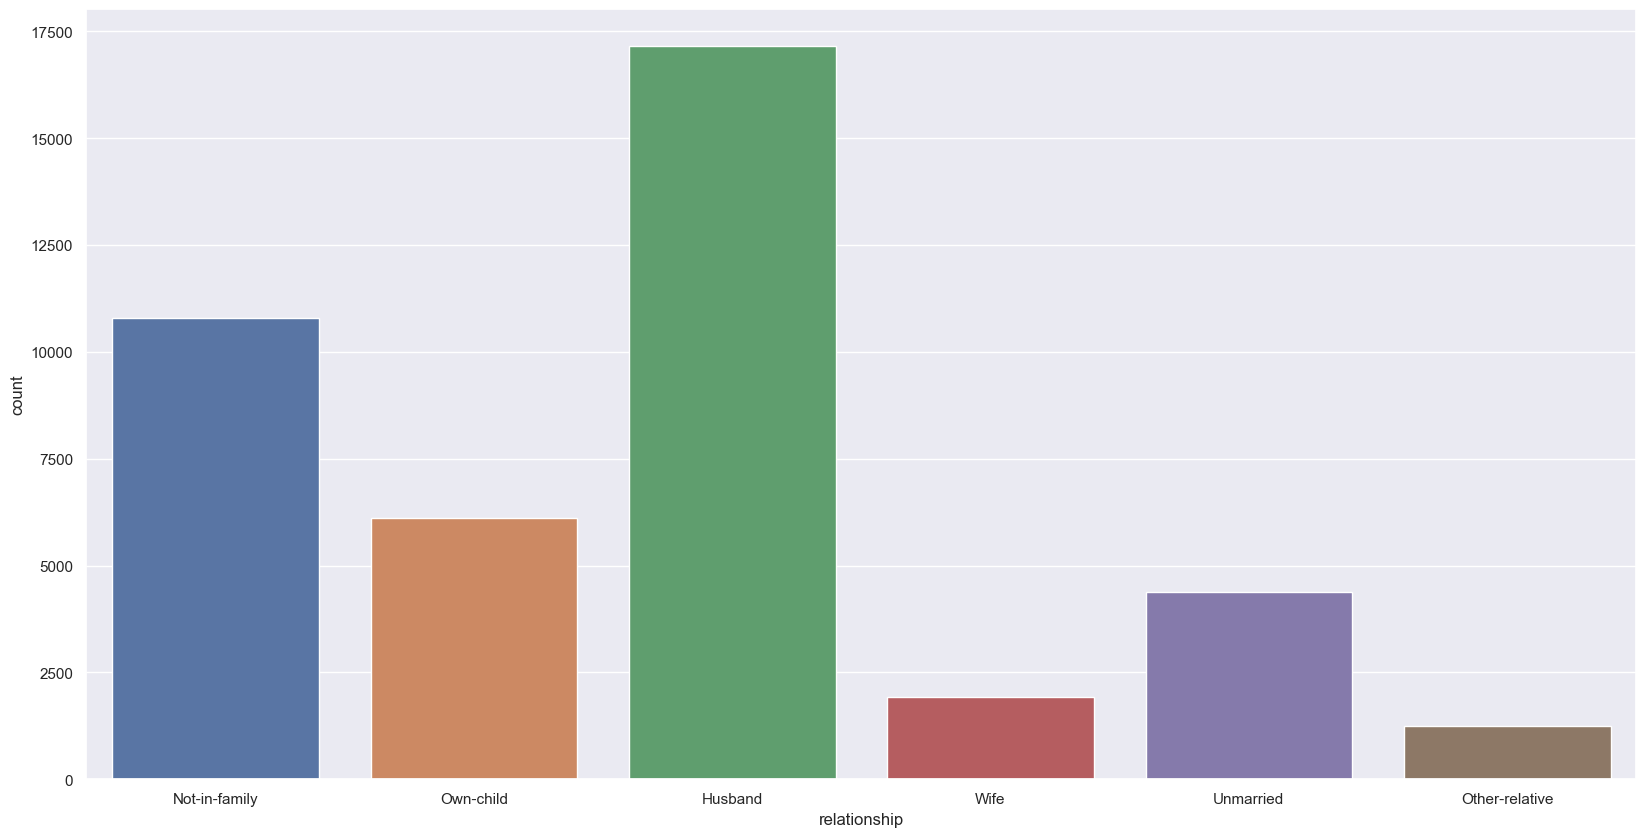

In [16]:
plt.figure(figsize=(20,10)) 
sns.countplot(data= combined_data_df, x = "relationship")

Большинство людей из этого датасета являются мужьями, либо не принадлежат никакой семье.

Рассмотрим расы людей из датасета.

<AxesSubplot: xlabel='race', ylabel='count'>

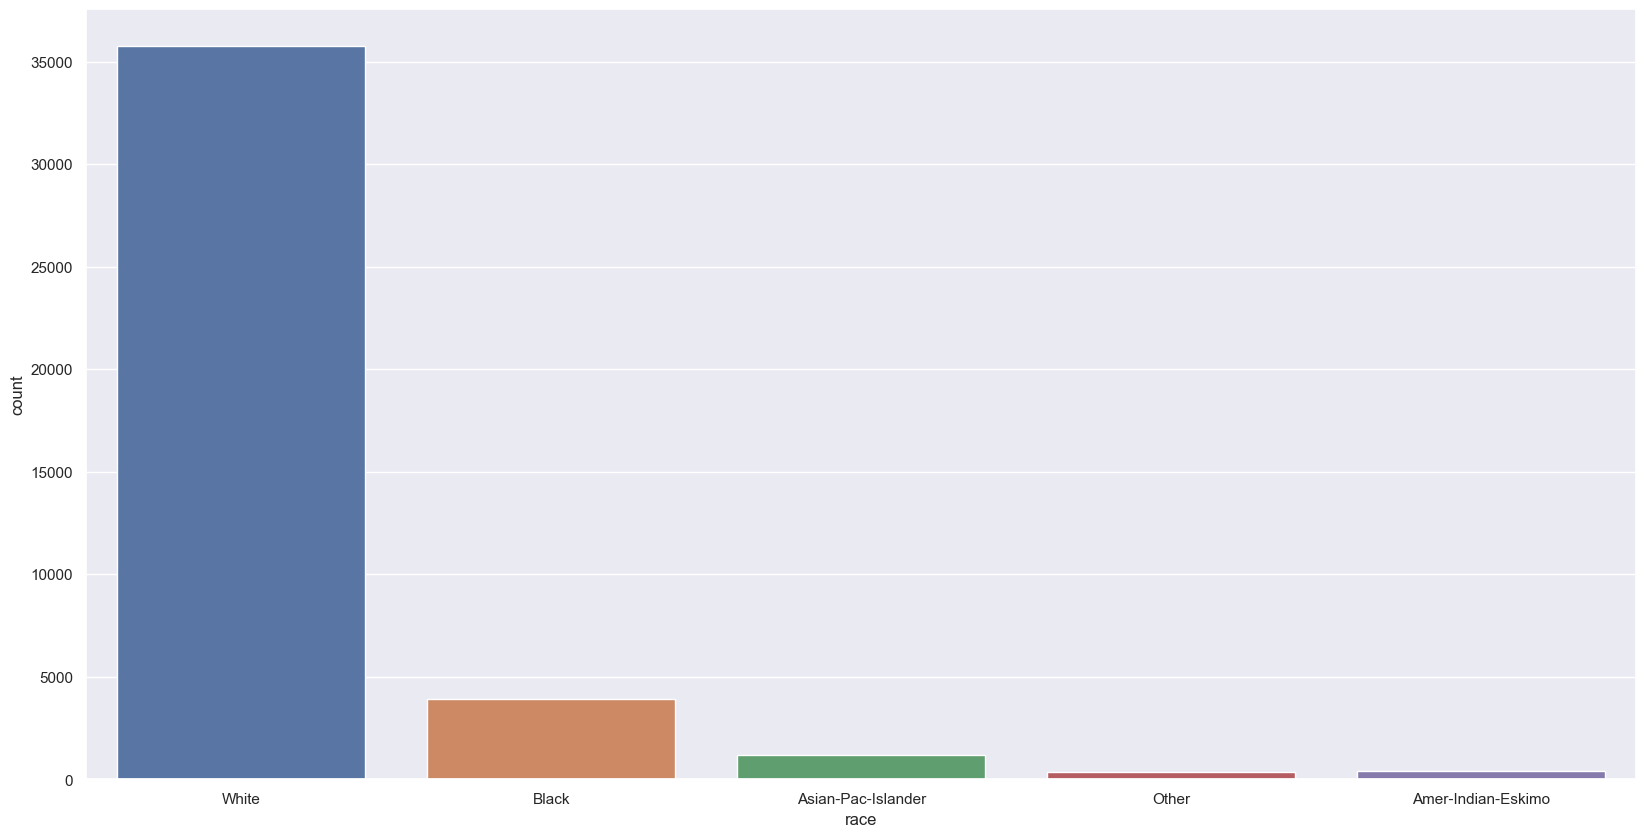

In [17]:
plt.figure(figsize=(20,10))
sns.countplot(data= combined_data_df, x = "race")

Большинство людей датасета -- белые.
Посмотрим на соотношение мужчин и женщин в датасете.

<AxesSubplot: xlabel='gender', ylabel='count'>

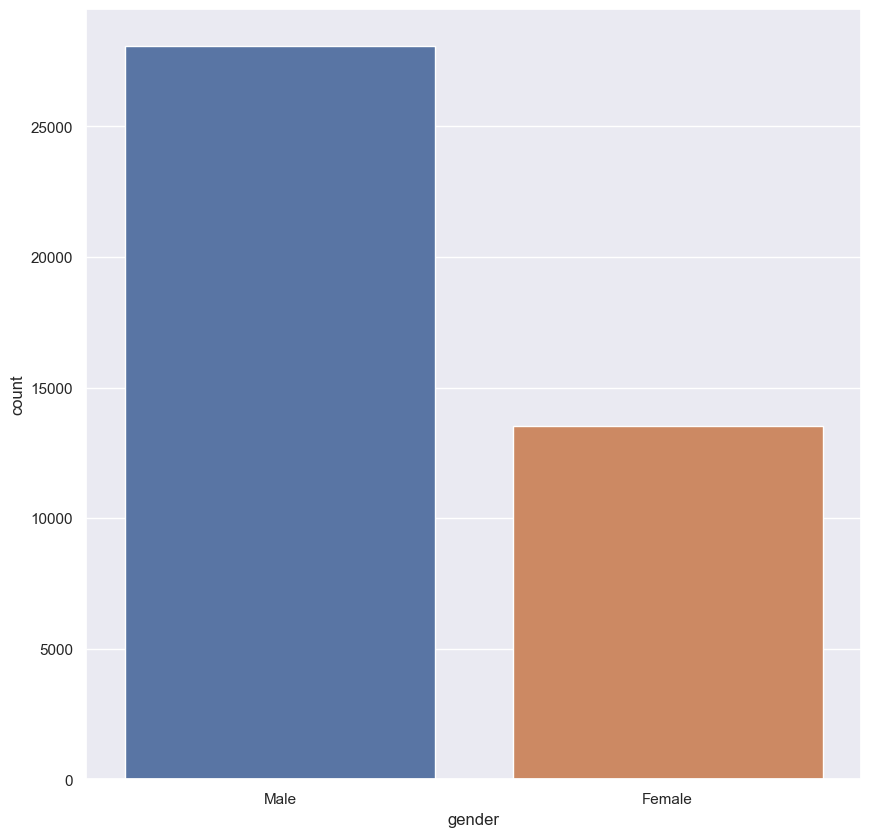

In [18]:
plt.figure(figsize=(10,10))
sns.countplot(data= combined_data_df, x = "gender")

Из графика видно, что в датасете примерно в два раза больше мужчин, чем женщин.

#### Категориальные vs количественные признаки

In [19]:
combined_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41606 entries, 0 to 898
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              41606 non-null  int64  
 1   workclass        41606 non-null  object 
 2   fnlwgt           41606 non-null  int64  
 3   education        41606 non-null  object 
 4   educational-num  41606 non-null  int64  
 5   marital-status   41606 non-null  object 
 6   occupation       41606 non-null  object 
 7   relationship     41606 non-null  object 
 8   race             41606 non-null  object 
 9   gender           41606 non-null  object 
 10  capital-gain     41606 non-null  int64  
 11  capital-loss     41606 non-null  int64  
 12  hours-per-week   41606 non-null  int64  
 13  income_>50K      40707 non-null  float64
 14  label            41606 non-null  object 
dtypes: float64(1), int64(6), object(8)
memory usage: 5.1+ MB


In [20]:
#categorical
cat_columns = [ col for col in list(combined_data_df.columns) if combined_data_df[col].dtype =='object' and col!= 'label']

cat_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender']

In [21]:
#numberical
num_columns = [ col for col in list(combined_data_df.columns) if combined_data_df[col].dtype in ['int64','float64']]
num_columns

['age',
 'fnlwgt',
 'educational-num',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'income_>50K']

Рассмотрим матрицу корелляции для количественных признаков.

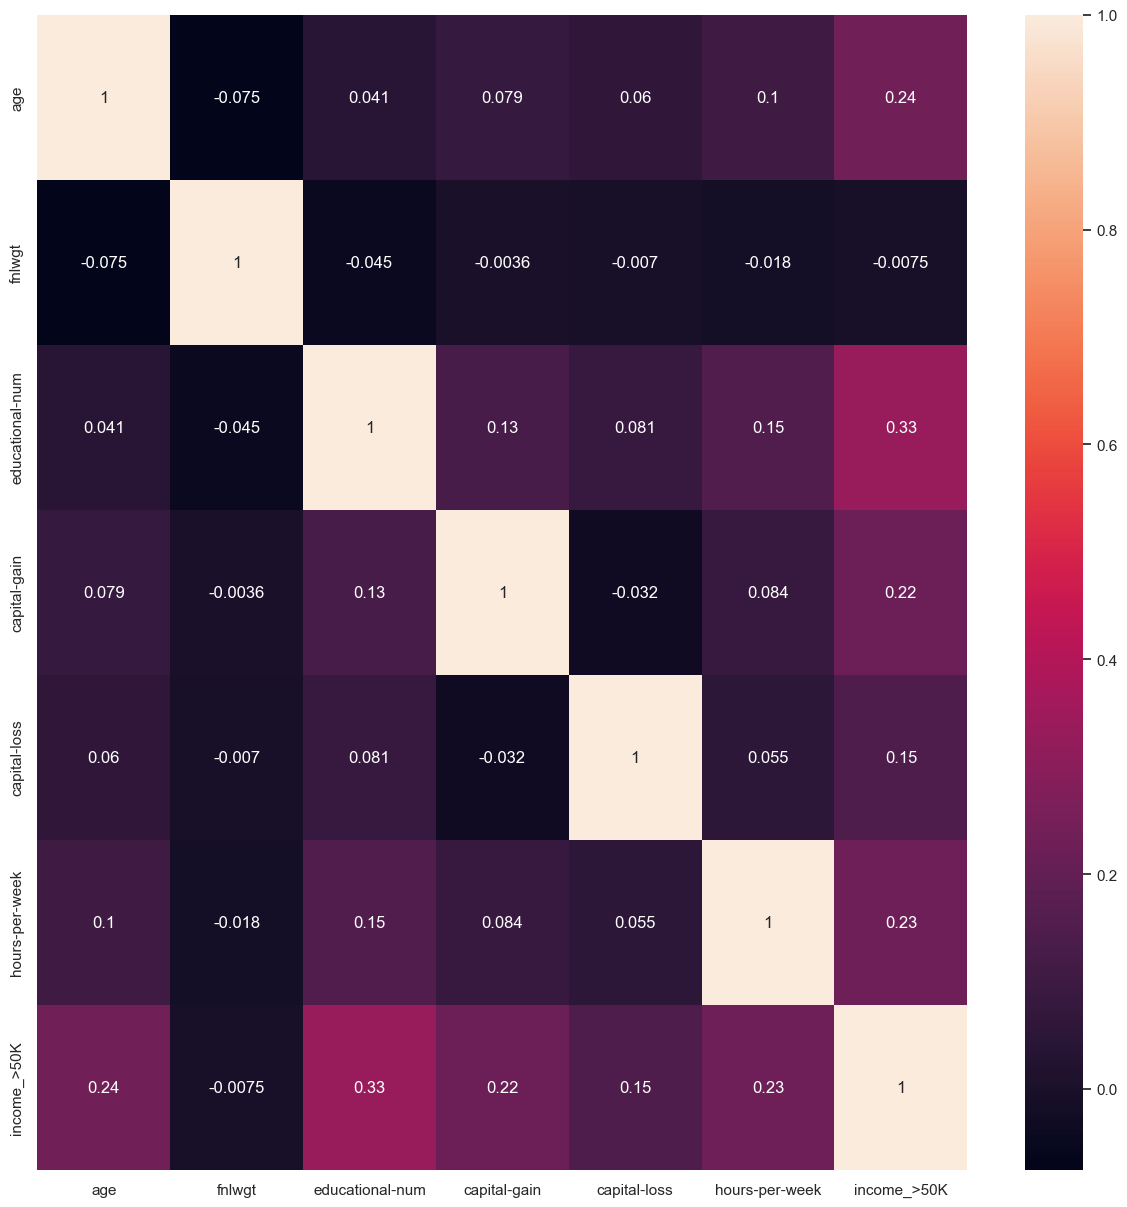

In [22]:
fig= plt.figure(figsize=(15,15))
corr_matrix = combined_data_df.corr()
sns.heatmap(data=corr_matrix,annot=True)
plt.show()

Видно, что признаки не кореллируют друг с другом, поэтому нет необходимости какой-либо удалять.
Сконвертируем категориальные признаки в количественные.

In [23]:
#get dummies
features_df = pd.get_dummies(data=combined_data_df, columns=cat_columns)
features_df.shape

(41606, 49)

In [24]:
features_df.columns

Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income_>50K', 'label', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'education_HS-grad', 'education_Preschool',
       'education_elementary-school', 'education_high-school',
       'education_middle-school', 'education_postsecondary-education',
       'marital-status_married', 'marital-status_single',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_H

### Формирование тренировочных и тестовых данных

In [25]:
#split your data
train_df = features_df[features_df['label'] == 'train']
test_df = features_df[features_df['label'] == 'test']

# Drop your labels
train_df = train_df.drop('label', axis=1)
test_df = test_df.drop(columns=['label','income_>50K'], axis=1)


train_df.shape, test_df.shape

((40707, 48), (899, 47))

In [26]:
train_df.columns

Index(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'income_>50K', 'workclass_Federal-gov',
       'workclass_Local-gov', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'education_HS-grad', 'education_Preschool',
       'education_elementary-school', 'education_high-school',
       'education_middle-school', 'education_postsecondary-education',
       'marital-status_married', 'marital-status_single',
       'occupation_Adm-clerical', 'occupation_Armed-Forces',
       'occupation_Craft-repair', 'occupation_Exec-managerial',
       'occupation_Farming-fishing', 'occupation_Handlers-cleaners',
       'occupation_Machine-op-inspct', 'occupation_Other-service',
       'occupation_Priv-house-serv', 'occupation_Prof-specialty',
       'occupation_Protective-serv', 'occupation_Sales',
       'occupation_Tech-support', 'occupation_Transport-moving',
       'relationship_Husband', 

In [27]:
y=train_df['income_>50K']
train_df=train_df.drop('income_>50K',axis=1)
train_df.shape,y.shape

((40707, 47), (40707,))

In [28]:
from sklearn.model_selection import train_test_split

X = train_df
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25)
X_train.shape, X_test.shape,y_train.shape,y_test.shape

((30530, 47), (10177, 47), (30530,), (10177,))

## Реализация алгоритма Bagging

In [29]:
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier

In [30]:
class BaggedDecisonTreeClassifier:
    
    def __init__(self,num_of_bagged = 5):
        # Initialised with number of bagged models
        self.num_of_bagged = num_of_bagged
        
    def fit(self, X, y, num_samples):
        # to store the models
        self.models = []
        for i in range(self.num_of_bagged):
            indexs = np.random.choice(num_samples,size=len(X))# sample with replacement
            X_i = X[indexs]# Chossing random samples
            Y_i = y[indexs]
            # Training for each sample bunch by Decision Tree Classifier
            model = DecisionTreeClassifier()
            #print("Xi shape = ", Xi.shape, Xi, len(indexs))
            model.fit(X_i, Y_i)
            # Storing the models
            self.models.append(model)
            
    def predict(self, X):
        pred = np.zeros(len(X))
        # predicting with each stored models
        for model in self.models:
            pred = pred + model.predict(X)
        return np.round(pred / self.num_of_bagged) # Model averaging
    
    def acc(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

## Реализация алгоритма AdaBoost

In [31]:
class MyAdaBoostClassifier:
    def __init__(self, n_estimators=50, learning_rate=1, base_estimator=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimators = []
        self.estimator_weights = np.zeros(n_estimators)
        self.estimator_errors = np.zeros(n_estimators)
        self.base_estimator = base_estimator

    def fit(self, X, y):
        # Initialize weights to 1/N
        w = np.ones(len(X)) / len(X)
        
        for i in range(self.n_estimators):
            # Train a weak learner
            self.base_estimator.fit(X, y, sample_weight=w)

            # Calculate the weighted error of the estimator
            y_pred = self.base_estimator.predict(X)
            incorrect = y_pred != y
            estimator_error = np.sum(w[incorrect])
            self.estimator_errors[i] = estimator_error

            # Calculate the weight of the estimator
            if estimator_error <= 0:
                self.estimator_weights[i] = 1
            else:
                self.estimator_weights[i] = self.learning_rate * np.log((1 - estimator_error) / estimator_error)

            # Update the weights
            w *= np.exp(self.estimator_weights[i] * incorrect * ((w > 0) | (self.estimator_weights[i] < 0)))

            # Normalize the weights
            w /= np.sum(w)

            # Save the estimator
            self.estimators.append(self.base_estimator)

    def get_params(self, deep=True):
        return {'n_estimators': self.n_estimators, 'learning_rate': self.learning_rate}

    def predict(self, X):
        y_pred = np.zeros(len(X))
        for i, estimator in enumerate(self.estimators):
            y_pred += self.estimator_weights[i] * estimator.predict(X)
        return np.sign(y_pred)

## Обучение моделей

In [32]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
import time

In [33]:
accuracy= [] 
recall =[]
roc_auc= []
precision = []
times = []

model_names =[]

In [34]:
from sklearn.metrics import accuracy_score

my_abcl = MyAdaBoostClassifier(n_estimators=100, learning_rate=1.0, base_estimator=DecisionTreeClassifier(max_depth=1))
start = time.time()
my_abcl.fit(X_train, y_train)
time_abcl = time.time() - start
y_pred_my_abcl = my_abcl.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred_my_abcl),4))
recall.append(round(recall_score(y_test, y_pred_my_abcl),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_my_abcl),4))
precision.append(round(precision_score(y_test, y_pred_my_abcl),4))
times.append(round(time_abcl, 4))
model_names.append('My AdaBoost')

In [35]:
from sklearn.model_selection import GridSearchCV, train_test_split


bdtc=BaggedDecisonTreeClassifier(10)
start = time.time()
bdtc.fit(np.asarray(X_train), np.asarray(y_train), int(len(X) / 5))
time_bdtc = time.time() - start
y_pred_bdtc=bdtc.predict(np.asarray(X_test))

accuracy.append(round(accuracy_score(y_test, y_pred_bdtc),4))
recall.append(round(recall_score(y_test, y_pred_bdtc),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_bdtc),4))
precision.append(round(precision_score(y_test, y_pred_bdtc),4))
times.append(round(time_bdtc, 4))

model_names.append('My bagging')

In [36]:
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier(n_estimators=10)
start = time.time()
rfclf = rfclf.fit(X_train, y_train)
time_rfclf = time.time() - start
y_pred_rfclf=rfclf.predict(X_test)
 
#accuracy_score(y_test, y_pred_clf)
accuracy.append(round(accuracy_score(y_test, y_pred_rfclf),4))
recall.append(round(recall_score(y_test, y_pred_rfclf),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_rfclf),4))
precision.append(round(precision_score(y_test, y_pred_rfclf),4))
times.append(round(time_rfclf, 4))

model_names.append('Random Forest')

In [37]:
from sklearn.ensemble import BaggingClassifier

bcl = BaggingClassifier(DecisionTreeClassifier())
start = time.time()
bcl.fit(X_train, y_train)
time_bcl = time.time() - start
y_pred_bcl = bcl.predict(X_test)

#accuracy_score(y_test, y_pred_bcl)
accuracy.append(round(accuracy_score(y_test, y_pred_bcl),4))
recall.append(round(recall_score(y_test, y_pred_bcl),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_bcl),4))
precision.append(round(precision_score(y_test, y_pred_bcl),4))
times.append(round(time_bcl, 4))

model_names.append('sklearn Bagging')

In [38]:
from sklearn.ensemble import AdaBoostClassifier

adacl = AdaBoostClassifier(n_estimators=100)
start = time.time()
adacl = adacl.fit(X_train, y_train)
time_adacl = time.time() - start
y_pred_adacl = adacl.predict(X_test)

#accuracy_score(y_test, y_pred_adacl)
accuracy.append(round(accuracy_score(y_test, y_pred_adacl),4))
recall.append(round(recall_score(y_test, y_pred_adacl),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_adacl),4))
precision.append(round(precision_score(y_test, y_pred_adacl),4))
times.append(round(time_adacl, 4))

model_names.append('sklearn AdaBoost')

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

gbcl = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
start = time.time()
gbcl = gbcl.fit(X_train, y_train)
time_gbcl = time.time() - start
y_pred_gbcl = gbcl.predict(X_test)

#accuracy_score(y_test, y_pred_gbcl)
accuracy.append(round(accuracy_score(y_test, y_pred_gbcl),4))
recall.append(round(recall_score(y_test, y_pred_gbcl),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_gbcl),4))
precision.append(round(precision_score(y_test, y_pred_gbcl),4))
times.append(round(time_gbcl, 4))

model_names.append('sklearn GradientBoosting')

In [40]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbcl = HistGradientBoostingClassifier(max_iter=100).fit(X_train, y_train)
start = time.time()
hgbcl = hgbcl.fit(X_train, y_train)
time_hgbcl = time.time() - start
y_pred_hgbcl = hgbcl.predict(X_test)

#accuracy_score(y_test, y_pred_hgbcl)
accuracy.append(round(accuracy_score(y_test, y_pred_hgbcl),4))
recall.append(round(recall_score(y_test, y_pred_hgbcl),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_hgbcl),4))
precision.append(round(precision_score(y_test, y_pred_hgbcl),4))
times.append(round(time_hgbcl, 4))

model_names.append('sklearn HGB')

### Сравнение с моделями XGBoost, LightGBM и CatBoost

In [41]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#### CatBoost

In [42]:
catboost_base = CatBoostClassifier(verbose=False,random_state=0)

start = time.time()
catboost_base.fit(X_train, y_train,eval_set=(X_test, y_test))
time_catboost = time.time() - start

y_pred_cat = catboost_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred_cat),4))
recall.append(round(recall_score(y_test, y_pred_cat),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_cat),4))
precision.append(round(precision_score(y_test, y_pred_cat),4))
times.append(round(time_catboost, 4))

model_names.append('Catboost_default')
result_df1 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision, 'Time':times}, index=model_names)

#### XGBoost

In [43]:
xgbc_base = XGBClassifier(random_state=0)

start = time.time()
xgbc_base.fit(X_train, y_train)
time_xgbc = time.time() - start
y_pred_xgbc = xgbc_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred_xgbc),4))
recall.append(round(recall_score(y_test, y_pred_xgbc),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_xgbc),4))
precision.append(round(precision_score(y_test, y_pred_xgbc),4))
times.append(round(time_xgbc, 4))

model_names.append('XGBoost_default')
result_df2 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)


#### LightGBM

In [44]:
lgbmc_base=LGBMClassifier(random_state=0)

start = time.time()
lgbmc_base.fit(X_train, y_train,eval_set=(X_test, y_test),feature_name='auto', verbose=0)
time_lgbmc = time.time() - start

y_pred_lgbmc = lgbmc_base.predict(X_test)

accuracy.append(round(accuracy_score(y_test, y_pred_lgbmc),4))
recall.append(round(recall_score(y_test, y_pred_lgbmc),4))
roc_auc.append(round(roc_auc_score(y_test, y_pred_lgbmc),4))
precision.append(round(precision_score(y_test, y_pred_lgbmc),4))

model_names.append('LightGBM_default')
result_df3 = pd.DataFrame({'Accuracy':accuracy,'Recall':recall, 'Roc_Auc':roc_auc, 'Precision':precision}, index=model_names)

In [45]:
result_df3

,Accuracy,Recall,Roc_Auc,Precision
My AdaBoost,0.7451,0.0227,0.5025,0.2953
My bagging,0.8328,0.5936,0.7524,0.6871
Random Forest,0.8458,0.5897,0.7598,0.7342
sklearn Bagging,0.8436,0.5793,0.7548,0.7318
sklearn AdaBoost,0.8614,0.6278,0.7829,0.7687
sklearn GradientBoosting,0.8623,0.6298,0.7842,0.7712
sklearn HGB,0.8693,0.6692,0.8021,0.7717
Catboost_default,0.8701,0.6553,0.7979,0.7836
XGBoost_default,0.8677,0.6577,0.7972,0.7733
LightGBM_default,0.8703,0.6652,0.8014,0.7778


ValueError: num must be 1 <= num <= 6, not 7

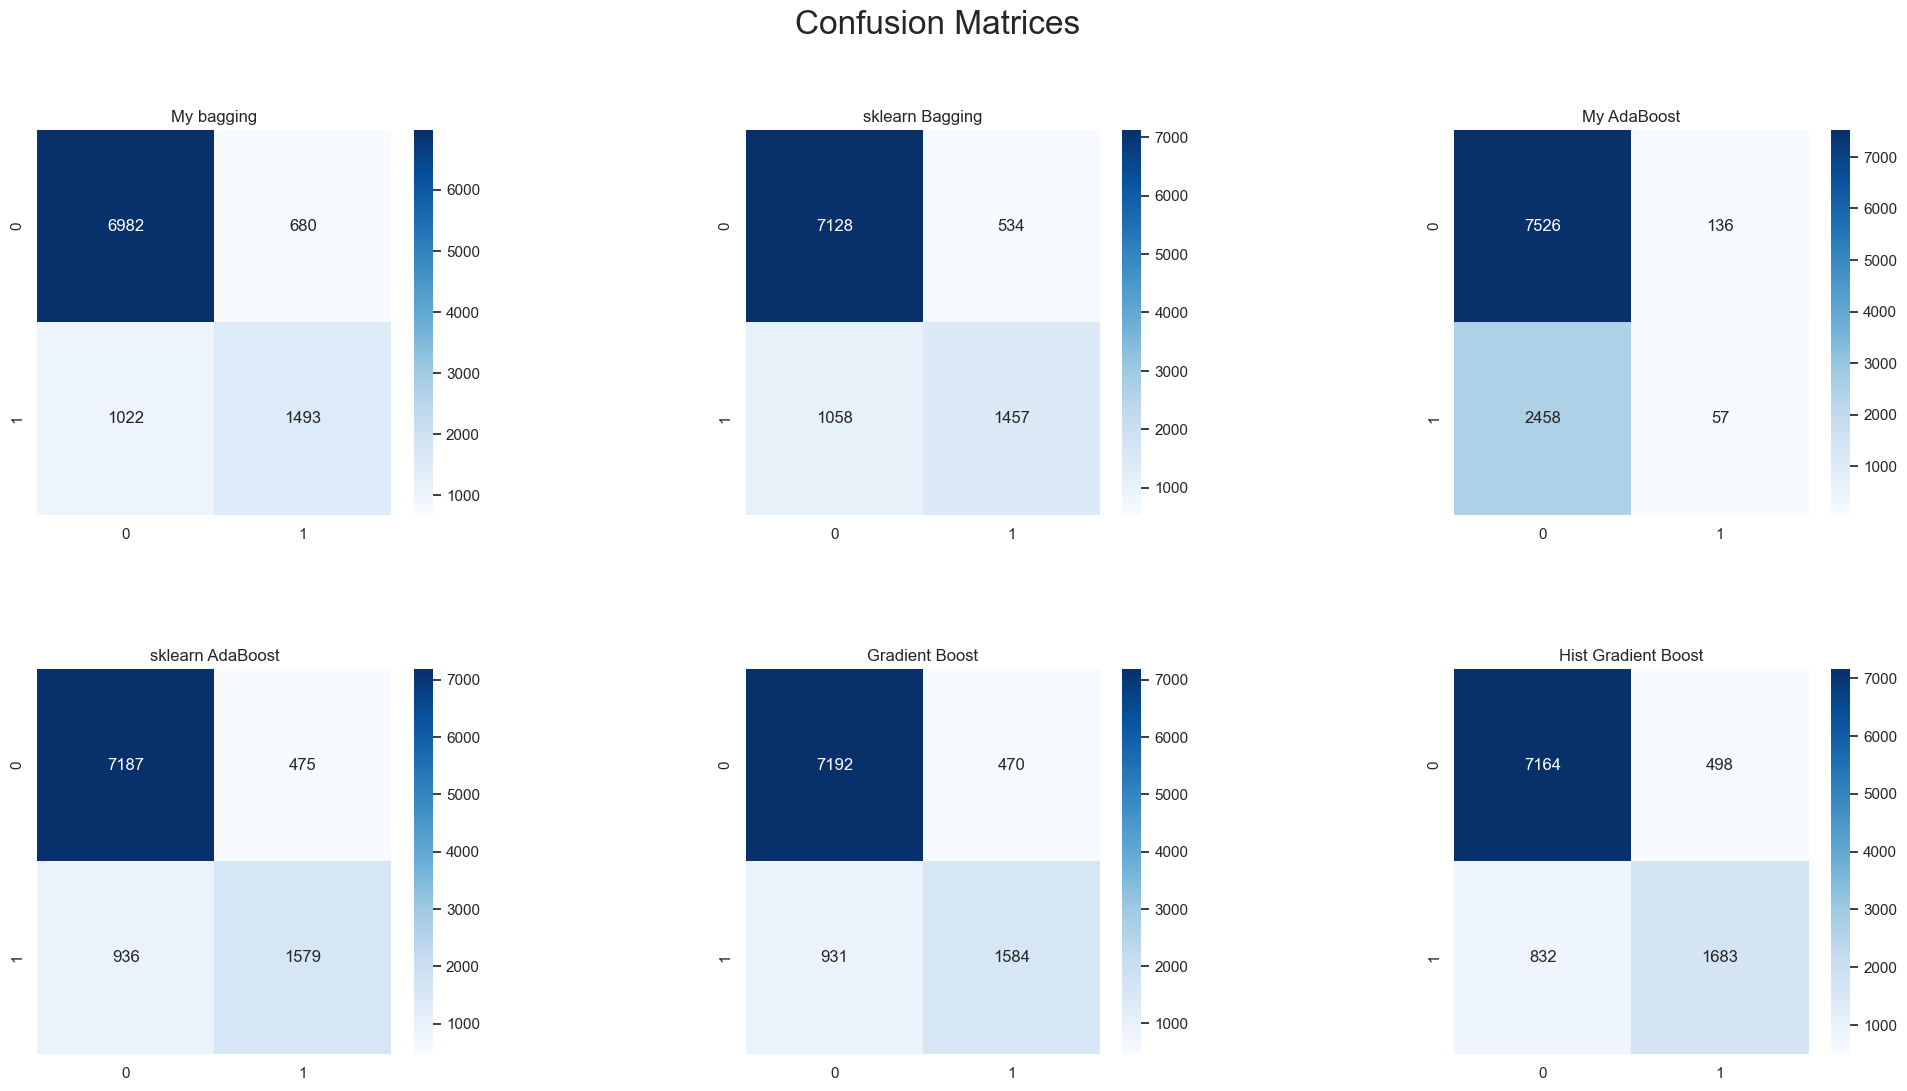

In [46]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(24, 12))

plt.suptitle("Confusion Matrices", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

plt.subplot(5, 2, 1)
plt.title("My bagging")
sns.heatmap(confusion_matrix(y_test, y_pred_bdtc), annot=True, fmt="d", cmap="Blues")

plt.subplot(5, 2, 2)
plt.title("sklearn Bagging")
sns.heatmap(confusion_matrix(y_test, y_pred_bcl), annot=True, fmt="d", cmap="Blues")

plt.subplot(5, 2, 3)
plt.title("My AdaBoost")
sns.heatmap(confusion_matrix(y_test, y_pred_my_abcl), annot=True, fmt="d", cmap="Blues")

plt.subplot(5, 2, 4)
plt.title("sklearn AdaBoost")
sns.heatmap(confusion_matrix(y_test, y_pred_adacl), annot=True, fmt="d", cmap="Blues")

plt.subplot(5, 2, 5)
plt.title("Gradient Boost")
sns.heatmap(confusion_matrix(y_test, y_pred_gbcl), annot=True, fmt="d", cmap="Blues")

plt.subplot(5, 2, 6)
plt.title("Hist Gradient Boost")
sns.heatmap(confusion_matrix(y_test, y_pred_hgbcl), annot=True, fmt="d", cmap="Blues")

plt.subplot(5, 2, 7)
plt.title("Random Forest")
sns.heatmap(confusion_matrix(y_test, y_pred_rfclf), annot=True, fmt="d", cmap="Blues")

plt.subplot(5, 2, 8)
plt.title("XGBoost")
sns.heatmap(confusion_matrix(y_test, y_pred_xgbc), annot=True, fmt="d", cmap="Blues")

plt.subplot(5, 2, 9)
plt.title("CatBoost")
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", cmap="Blues")

plt.subplot(5, 2, 10)
plt.title("LightGBM")
sns.heatmap(confusion_matrix(y_test, y_pred_lgbmc), annot=True, fmt="d", cmap="Blues")

plt.show()